In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import os
import sys
sys.path.append('./..')
sys.path.append('./../..')
from pandarallel.utils.inliner import inline
from tqdm import tqdm
from collections import OrderedDict
try:
    from data_fetcher import data_fetcher
except:
    from .data_fetcher import data_fetcher
try:
    from model import model_6_v1 as Model
except:
    from .model import model_6_v1 as Model

from pathlib import Path
import multiprocessing
from pprint import pprint
import torch
import math
import yaml
from sklearn.metrics import auc

INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
Current device  >>  cuda


In [3]:
from matplotlib import pyplot as plt

In [4]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# DEVICE = torch.device("cpu")
print('Current device  >> ', DEVICE)

Current device  >>  cuda


In [5]:
def visualize( model_obj, x1,x2 ):
   
    from sklearn.decomposition import TruncatedSVD
    try :
        %matplotlib inline
    except:
        pass
    import matplotlib.pyplot as plt
    
    x1 = model_obj.get_compressed_embedding(x1)
    x2 = model_obj.get_compressed_embedding(x2)
    
    svd = TruncatedSVD(n_components=2, n_iter=100, random_state=42)
    x = np.vstack([x1,x2])
    x3 = svd.fit_transform(x)

    plt.figure(figsize=[10,10])
    plt.scatter(x3[:len(x1),0], x3[:len(x1),1], c='g',alpha=0.95)
    plt.scatter(x3[len(x1):,0], x3[len(x1):,1], c='r',alpha=0.35)
    plt.show()
    
    svd = TruncatedSVD(n_components=3, n_iter=100, random_state=42)
    x = np.vstack([x1,x2])
    x3 = svd.fit_transform(x)
    fig = plt.figure(figsize=[14,14])
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter( x3[:len(x1),0], x3[:len(x1),1], x3[:len(x1),2], c ='g',alpha=0.95 , marker='^')
    ax.scatter( x3[len(x1):,0], x3[len(x1):,1], x3[len(x1):,2], c ='r',alpha=0.35 , marker='v')

    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')

    plt.show()
    return

In [6]:

def create_config(
        data_set
):
    # Should return :
    # data_dict
    # meta_data_df [column, dimension]

    config_file = 'architecture_config.yaml'
    
    with open(config_file, 'r') as fh :
        config = yaml.safe_load(fh)
    config = config[data_set]
    latent_dim = config['ae_latent_dimension']

    data_dict, meta_data_df = data_fetcher.get_data(data_set,True)

    # discrete_columns : { column_name : num_categories }
    discrete_dims = OrderedDict ({k: v for k, v in zip(list(meta_data_df['column']), list(meta_data_df['dimension']))})
    num_discrete_columns = len(discrete_dims)
    count_discrete_dims = 0
    for val in discrete_dims.values():
        if val == 2:
            count_discrete_dims += 1
        else:
            count_discrete_dims += val
            
    real_dims = len(data_dict['train'].columns) - count_discrete_dims

    # ---------------
    # encoder_structure_config['ip_layers']
    # Format :
    # [ 'emb|onehot', num_categories, [ embedding dimension ]
    # ---------------
    encoder_structure_config = {
        'real_dims': real_dims,
        'discrete_dims': discrete_dims,
        'encoder_FCN_to_latent': config['encoder_FCN_to_latent'],
        'ae_latent_dimension' :  config['ae_latent_dimension'],
        'encoder_discrete_xform' : config['encoder_discrete_xform'],
        'encoder_real_xform' : config['encoder_real_xform']
    }

    # ======================================================
    # Set decoder structure
    # =========

    decoder_structure_config = {
        'real_dims': real_dims,
        'discrete_dims': discrete_dims,
        'decoder_FC_from_latent': config['decoder_FC_from_latent'],
        'decoder_discrete_xform' : config['decoder_discrete_xform'],
        'decoder_real_xform' : config['decoder_real_xform'],
        'ae_latent_dimension': config['ae_latent_dimension']
    }

    # ================
    # Format decoder_field_layers:
    # { idx : [[dim1,dim2], op_activation ]
    # ================
    loss_structure_config = {
        'discrete_dims' : discrete_dims,
        'real_loss_func': config['real_loss_func'],
        'real_dims':  real_dims
    }

    return encoder_structure_config, decoder_structure_config, loss_structure_config, latent_dim

encoder_structure_config, decoder_structure_config, loss_structure_config, latent_dim = create_config('kddcup')
pprint(encoder_structure_config)
pprint(decoder_structure_config)


{'ae_latent_dimension': 8,
 'discrete_dims': OrderedDict([('protocol_type', 3),
                               ('service', 65),
                               ('flag', 11),
                               ('land', 2),
                               ('logged_in', 2),
                               ('is_guest_login', 2)]),
 'encoder_FCN_to_latent': {'activation': 'tanh', 'dims': [64, 32]},
 'encoder_discrete_xform': {'service': {'activation': 'none', 'dims': [8]}},
 'encoder_real_xform': {'activation': 'tanh', 'dims': [16]},
 'real_dims': 34}
{'ae_latent_dimension': 8,
 'decoder_FC_from_latent': {'activation': 'tanh', 'dims': [32, 64]},
 'decoder_discrete_xform': {'flag': {'activation': 'tanh', 'dims': None},
                            'is_guest_login': {'activation': 'tanh',
                                               'dims': None},
                            'land': {'activation': 'tanh', 'dims': None},
                            'logged_in': {'activation': 'tanh', 'dims': None},


In [7]:
loss_structure_config


{'discrete_dims': OrderedDict([('protocol_type', 3),
              ('service', 65),
              ('flag', 11),
              ('land', 2),
              ('logged_in', 2),
              ('is_guest_login', 2)]),
 'real_loss_func': 'smooth_l1',
 'real_dims': 34}

In [8]:
import model_data_fetcher
# ======================================= #

# data_dict, _ = data_fetcher.get_data('kddcup', one_hot=True, num_anom_sets=num_anomaly_sets)


num_anomaly_sets = 5
anomaly_ratio = 0.2

pos, neg_x, data_dict = model_data_fetcher.fetch_model_data('kddcup',num_anom_sets=num_anomaly_sets,anomaly_ratio=anomaly_ratio)

INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


100%|██████████| 97278/97278 [10:50<00:00, 149.62it/s]


Size {:.3f} 51.16135311126709  MB 
Size {:.3f} 702.036039352417  MB 
>  972780 121597


In [9]:
try:
    from model import model_6_v1_container as Model
except:
    from .model import model_6_v1_container as Model
    
ae_model =  Model(
    DEVICE,
    latent_dim,
    encoder_structure_config,
    decoder_structure_config,
    loss_structure_config,
    batch_size=128,
    learning_rate=0.005,
    max_gamma=5,
    ae_dropout=0.2,
    fc_dropout = 0.1,
    burn_in_epochs=15,
    phase_2_epochs=10,
    phase_3_epochs=10
)

print(ae_model.network_module)

split schema  [3, 65, 11, 1, 1, 1, 34]
Loss structure config {'discrete_dims': OrderedDict([('protocol_type', 3), ('service', 65), ('flag', 11), ('land', 2), ('logged_in', 2), ('is_guest_login', 2)]), 'real_loss_func': 'smooth_l1', 'real_dims': 34}
 Loss module split schema  [3, 65, 11, 1, 1, 1, 34]
Normal(loc: torch.Size([8]), scale: torch.Size([8]))
model_6_v1(
  (ae_module): AE(
    (encoder): AE_encoder(
      (input_x_form_layers): ModuleList(
        (0): Identity()
        (1): Sequential(
          (0): Linear(in_features=65, out_features=8, bias=True)
          (1): Identity()
        )
        (2): Identity()
        (3): Identity()
        (4): Identity()
        (5): Identity()
        (6): Sequential(
          (0): Linear(in_features=34, out_features=16, bias=True)
          (1): Tanh()
        )
      )
      (FC_z): Sequential(
        (0): Linear(in_features=41, out_features=64, bias=True)
        (1): Dropout(p=0.2, inplace=False)
        (2): Tanh()
        (3): Line

In [10]:
losses = ae_model.train_model(
    pos, 
    neg_x
)

  0%|          | 0/35 [00:00<?, ?it/s]

 Epoch 1 Batch 0 Loss 82.0200 || AE 82.0200 1.4165 
 Epoch 1 Batch 100 Loss 56.6837 || AE 56.6837 1.3783 
 Epoch 1 Batch 200 Loss 56.6732 || AE 56.6732 1.3917 
 Epoch 1 Batch 300 Loss 56.5914 || AE 56.5914 1.4001 
 Epoch 1 Batch 400 Loss 56.6549 || AE 56.6549 1.3911 
 Epoch 1 Batch 500 Loss 56.6940 || AE 56.6940 1.3897 


  3%|▎         | 1/35 [00:26<14:44, 26.01s/it]

Epoch loss :: 57.01819
 Epoch 2 Batch 0 Loss 56.4238 || AE 56.4238 1.3895 
 Epoch 2 Batch 100 Loss 56.6430 || AE 56.6430 1.3940 
 Epoch 2 Batch 200 Loss 56.6939 || AE 56.6939 1.3855 
 Epoch 2 Batch 300 Loss 56.6898 || AE 56.6898 1.3944 
 Epoch 2 Batch 400 Loss 56.6457 || AE 56.6457 1.4071 
 Epoch 2 Batch 500 Loss 56.4633 || AE 56.4633 1.3955 


  6%|▌         | 2/35 [00:51<14:15, 25.92s/it]

Epoch loss :: 56.616158
 Epoch 3 Batch 0 Loss 56.6973 || AE 56.6973 1.3817 
 Epoch 3 Batch 100 Loss 56.5338 || AE 56.5338 1.3974 
 Epoch 3 Batch 200 Loss 56.4610 || AE 56.4610 1.3926 
 Epoch 3 Batch 300 Loss 56.2818 || AE 56.2818 1.3921 
 Epoch 3 Batch 400 Loss 56.4419 || AE 56.4419 1.3847 
 Epoch 3 Batch 500 Loss 56.7012 || AE 56.7012 1.3839 


  9%|▊         | 3/35 [01:17<13:48, 25.88s/it]

Epoch loss :: 56.615284
 Epoch 4 Batch 0 Loss 56.6180 || AE 56.6180 1.4053 
 Epoch 4 Batch 100 Loss 56.8914 || AE 56.8914 1.3827 
 Epoch 4 Batch 200 Loss 56.6343 || AE 56.6343 1.3893 
 Epoch 4 Batch 300 Loss 56.5935 || AE 56.5935 1.4008 
 Epoch 4 Batch 400 Loss 56.6989 || AE 56.6989 1.3908 
 Epoch 4 Batch 500 Loss 56.5491 || AE 56.5491 1.4051 


 11%|█▏        | 4/35 [01:42<13:15, 25.65s/it]

Epoch loss :: 56.614525
 Epoch 5 Batch 0 Loss 56.8724 || AE 56.8724 1.4033 
 Epoch 5 Batch 100 Loss 56.7010 || AE 56.7010 1.3981 
 Epoch 5 Batch 200 Loss 56.7111 || AE 56.7111 1.3901 
 Epoch 5 Batch 300 Loss 56.7380 || AE 56.7380 1.4002 
 Epoch 5 Batch 400 Loss 56.5621 || AE 56.5621 1.3982 
 Epoch 5 Batch 500 Loss 56.5891 || AE 56.5891 1.4083 


 14%|█▍        | 5/35 [02:08<12:48, 25.60s/it]

Epoch loss :: 56.6145
 Epoch 6 Batch 0 Loss 56.6036 || AE 56.6036 1.3966 
 Epoch 6 Batch 100 Loss 56.6538 || AE 56.6538 1.3880 
 Epoch 6 Batch 200 Loss 56.6813 || AE 56.6813 1.3904 
 Epoch 6 Batch 300 Loss 56.6694 || AE 56.6694 1.3835 
 Epoch 6 Batch 400 Loss 56.5247 || AE 56.5247 1.3986 
 Epoch 6 Batch 500 Loss 56.9327 || AE 56.9327 1.3845 


 17%|█▋        | 6/35 [02:33<12:19, 25.49s/it]

Epoch loss :: 56.614525
 Epoch 7 Batch 0 Loss 56.5923 || AE 56.5923 1.3884 
 Epoch 7 Batch 100 Loss 56.7124 || AE 56.7124 1.3836 
 Epoch 7 Batch 200 Loss 56.5343 || AE 56.5343 1.4004 
 Epoch 7 Batch 300 Loss 56.4980 || AE 56.4980 1.3880 
 Epoch 7 Batch 400 Loss 56.4594 || AE 56.4594 1.3956 
 Epoch 7 Batch 500 Loss 56.7484 || AE 56.7484 1.4051 


 20%|██        | 7/35 [02:59<11:59, 25.69s/it]

Epoch loss :: 56.614697
 Epoch 8 Batch 0 Loss 56.3903 || AE 56.3903 1.3927 
 Epoch 8 Batch 100 Loss 56.8049 || AE 56.8049 1.4055 
 Epoch 8 Batch 200 Loss 56.8251 || AE 56.8251 1.3963 
 Epoch 8 Batch 300 Loss 56.7451 || AE 56.7451 1.4023 
 Epoch 8 Batch 400 Loss 56.5297 || AE 56.5297 1.3901 
 Epoch 8 Batch 500 Loss 56.4784 || AE 56.4784 1.3934 


 23%|██▎       | 8/35 [03:24<11:30, 25.59s/it]

Epoch loss :: 56.614185
 Epoch 9 Batch 0 Loss 56.6323 || AE 56.6323 1.3925 
 Epoch 9 Batch 100 Loss 56.7277 || AE 56.7277 1.3893 
 Epoch 9 Batch 200 Loss 56.5565 || AE 56.5565 1.3811 
 Epoch 9 Batch 300 Loss 56.4935 || AE 56.4935 1.3842 
 Epoch 9 Batch 400 Loss 56.4630 || AE 56.4630 1.3926 
 Epoch 9 Batch 500 Loss 56.6097 || AE 56.6097 1.4005 


 26%|██▌       | 9/35 [03:50<11:02, 25.49s/it]

Epoch loss :: 56.614273
 Epoch 10 Batch 0 Loss 56.5699 || AE 56.5699 1.3850 
 Epoch 10 Batch 100 Loss 56.5017 || AE 56.5017 1.3949 
 Epoch 10 Batch 200 Loss 56.5155 || AE 56.5155 1.4027 
 Epoch 10 Batch 300 Loss 56.9016 || AE 56.9016 1.3787 
 Epoch 10 Batch 400 Loss 56.5646 || AE 56.5646 1.3947 
 Epoch 10 Batch 500 Loss 56.6090 || AE 56.6090 1.3851 


 29%|██▊       | 10/35 [04:16<10:40, 25.63s/it]

Epoch loss :: 56.614574
 Epoch 11 Batch 0 Loss 56.6561 || AE 56.6561 1.3863 
 Epoch 11 Batch 100 Loss 56.5777 || AE 56.5777 1.3948 
 Epoch 11 Batch 200 Loss 56.6782 || AE 56.6782 1.3949 
 Epoch 11 Batch 300 Loss 56.8864 || AE 56.8864 1.3870 
 Epoch 11 Batch 400 Loss 56.6264 || AE 56.6264 1.3850 
 Epoch 11 Batch 500 Loss 56.3815 || AE 56.3815 1.4072 


 31%|███▏      | 11/35 [04:40<10:09, 25.41s/it]

Epoch loss :: 56.614365
 Epoch 12 Batch 0 Loss 56.4772 || AE 56.4772 1.3923 
 Epoch 12 Batch 100 Loss 56.5656 || AE 56.5656 1.3908 
 Epoch 12 Batch 200 Loss 56.6746 || AE 56.6746 1.3992 
 Epoch 12 Batch 300 Loss 56.1940 || AE 56.1940 1.4103 
 Epoch 12 Batch 400 Loss 56.2797 || AE 56.2797 1.3916 
 Epoch 12 Batch 500 Loss 56.2537 || AE 56.2537 1.4086 


 34%|███▍      | 12/35 [05:06<09:47, 25.54s/it]

Epoch loss :: 56.387318
 Epoch 13 Batch 0 Loss 56.1596 || AE 56.1596 1.4233 
 Epoch 13 Batch 100 Loss 56.2669 || AE 56.2669 1.4253 
 Epoch 13 Batch 200 Loss 56.2480 || AE 56.2480 1.4159 
 Epoch 13 Batch 300 Loss 56.1457 || AE 56.1457 1.4278 
 Epoch 13 Batch 400 Loss 56.2345 || AE 56.2345 1.4326 
 Epoch 13 Batch 500 Loss 56.0843 || AE 56.0843 1.4294 


 37%|███▋      | 13/35 [05:32<09:20, 25.49s/it]

Epoch loss :: 56.149048
 Epoch 14 Batch 0 Loss 56.1892 || AE 56.1892 1.4101 
 Epoch 14 Batch 100 Loss 56.1091 || AE 56.1091 1.4355 
 Epoch 14 Batch 200 Loss 56.1227 || AE 56.1227 1.4153 
 Epoch 14 Batch 300 Loss 56.0523 || AE 56.0523 1.4444 
 Epoch 14 Batch 400 Loss 56.1560 || AE 56.1560 1.4286 
 Epoch 14 Batch 500 Loss 56.2071 || AE 56.2071 1.4246 


 40%|████      | 14/35 [05:58<09:00, 25.72s/it]

Epoch loss :: 56.148823
 Epoch 15 Batch 0 Loss 1.4313 || AE 56.2183 1.4313 
 Epoch 15 Batch 100 Loss 0.2255 || AE 56.2380 0.2255 
 Epoch 15 Batch 200 Loss 0.0653 || AE 56.1206 0.0653 
 Epoch 15 Batch 300 Loss 0.0573 || AE 56.1854 0.0573 
 Epoch 15 Batch 400 Loss 0.0353 || AE 56.2340 0.0353 
 Epoch 15 Batch 500 Loss 0.0236 || AE 56.2607 0.0236 


 43%|████▎     | 15/35 [06:32<09:22, 28.12s/it]

Epoch loss :: 0.1998983
 Epoch 16 Batch 0 Loss 20.7166 || AE 56.1815 0.0485 
 Epoch 16 Batch 100 Loss 20.7562 || AE 56.2740 0.0541 
 Epoch 16 Batch 200 Loss 20.9332 || AE 56.1401 0.2804 
 Epoch 16 Batch 300 Loss 20.6917 || AE 56.1855 0.0222 
 Epoch 16 Batch 400 Loss 20.7666 || AE 56.0825 0.1350 
 Epoch 16 Batch 500 Loss 20.9521 || AE 56.1449 0.2976 


 46%|████▌     | 16/35 [07:01<08:59, 28.37s/it]

Epoch loss :: 20.685478
 Epoch 17 Batch 0 Loss 7.6084 || AE 56.0996 0.0162 
 Epoch 17 Batch 100 Loss 7.6023 || AE 56.0617 0.0152 
 Epoch 17 Batch 200 Loss 7.6341 || AE 56.2633 0.0197 
 Epoch 17 Batch 300 Loss 7.6226 || AE 56.1865 0.0186 
 Epoch 17 Batch 400 Loss 7.6179 || AE 56.1910 0.0133 
 Epoch 17 Batch 500 Loss 7.6336 || AE 56.2200 0.0250 


 49%|████▊     | 17/35 [07:31<08:42, 29.00s/it]

Epoch loss :: 7.6161613
 Epoch 18 Batch 0 Loss 2.8216 || AE 56.2507 0.0211 
 Epoch 18 Batch 100 Loss 2.8053 || AE 56.1301 0.0107 
 Epoch 18 Batch 200 Loss 2.8052 || AE 56.1305 0.0106 
 Epoch 18 Batch 300 Loss 2.8027 || AE 56.1110 0.0091 
 Epoch 18 Batch 400 Loss 2.8121 || AE 56.1069 0.0187 
 Epoch 18 Batch 500 Loss 2.8134 || AE 56.1592 0.0174 


 51%|█████▏    | 18/35 [08:01<08:18, 29.29s/it]

Epoch loss :: 2.806837
 Epoch 19 Batch 0 Loss 1.0340 || AE 56.1215 0.0061 
 Epoch 19 Batch 100 Loss 1.0506 || AE 56.0442 0.0241 
 Epoch 19 Batch 200 Loss 1.0400 || AE 56.0592 0.0132 
 Epoch 19 Batch 300 Loss 1.0372 || AE 56.1604 0.0086 
 Epoch 19 Batch 400 Loss 1.0360 || AE 56.1065 0.0084 
 Epoch 19 Batch 500 Loss 1.0390 || AE 56.0294 0.0127 


 54%|█████▍    | 19/35 [08:30<07:44, 29.04s/it]

Epoch loss :: 1.0384146
 Epoch 20 Batch 0 Loss 0.3988 || AE 56.0609 0.0211 
 Epoch 20 Batch 100 Loss 0.3834 || AE 56.1198 0.0053 
 Epoch 20 Batch 200 Loss 0.3954 || AE 56.0225 0.0180 
 Epoch 20 Batch 300 Loss 0.3831 || AE 56.0368 0.0056 
 Epoch 20 Batch 400 Loss 0.3817 || AE 56.0581 0.0040 
 Epoch 20 Batch 500 Loss 0.3833 || AE 56.1626 0.0049 


 57%|█████▋    | 20/35 [09:03<07:33, 30.24s/it]

Epoch loss :: 0.3842006
 Epoch 21 Batch 0 Loss 0.1441 || AE 56.1301 0.0050 
 Epoch 21 Batch 100 Loss 0.1517 || AE 56.1371 0.0126 
 Epoch 21 Batch 200 Loss 0.1427 || AE 56.0932 0.0037 
 Epoch 21 Batch 300 Loss 0.1416 || AE 56.0877 0.0026 
 Epoch 21 Batch 400 Loss 0.1427 || AE 56.0673 0.0037 
 Epoch 21 Batch 500 Loss 0.1416 || AE 56.1740 0.0023 


 60%|██████    | 21/35 [09:32<06:57, 29.86s/it]

Epoch loss :: 0.14454502
 Epoch 22 Batch 0 Loss 0.0538 || AE 56.2545 0.0025 
 Epoch 22 Batch 100 Loss 0.0546 || AE 56.1579 0.0034 
 Epoch 22 Batch 200 Loss 0.0567 || AE 56.0109 0.0056 
 Epoch 22 Batch 300 Loss 0.0637 || AE 56.0908 0.0125 
 Epoch 22 Batch 400 Loss 0.0547 || AE 56.1360 0.0036 
 Epoch 22 Batch 500 Loss 0.0554 || AE 56.1201 0.0043 


 63%|██████▎   | 22/35 [10:00<06:21, 29.31s/it]

Epoch loss :: 0.056499552
 Epoch 23 Batch 0 Loss 0.0294 || AE 56.2432 0.0105 
 Epoch 23 Batch 100 Loss 0.0218 || AE 56.0691 0.0030 
 Epoch 23 Batch 200 Loss 0.0211 || AE 56.1746 0.0023 
 Epoch 23 Batch 300 Loss 0.0253 || AE 56.2979 0.0064 
 Epoch 23 Batch 400 Loss 0.0207 || AE 56.0885 0.0019 
 Epoch 23 Batch 500 Loss 0.0289 || AE 56.3026 0.0100 


 66%|██████▌   | 23/35 [10:28<05:46, 28.91s/it]

Epoch loss :: 0.02695435
 Epoch 24 Batch 0 Loss 0.0104 || AE 56.2581 0.0035 
 Epoch 24 Batch 100 Loss 0.0097 || AE 56.0823 0.0027 
 Epoch 24 Batch 200 Loss 0.0159 || AE 56.3095 0.0089 
 Epoch 24 Batch 300 Loss 0.0250 || AE 56.1379 0.0181 
 Epoch 24 Batch 400 Loss 0.1273 || AE 56.0915 0.1204 
 Epoch 24 Batch 500 Loss 0.0106 || AE 55.9787 0.0037 


 69%|██████▊   | 24/35 [10:57<05:20, 29.15s/it]

Epoch loss :: 0.016881416
 Epoch 25 Batch 0 Loss 0.0165 || AE 56.2087 0.0165 
 Epoch 25 Batch 100 Loss 0.0026 || AE 56.2547 0.0026 
 Epoch 25 Batch 200 Loss 0.0143 || AE 56.3025 0.0143 
 Epoch 25 Batch 300 Loss 0.0022 || AE 56.0883 0.0022 
 Epoch 25 Batch 400 Loss 0.0023 || AE 56.0649 0.0023 
 Epoch 25 Batch 500 Loss 0.0033 || AE 56.1882 0.0033 


 71%|███████▏  | 25/35 [11:27<04:54, 29.42s/it]

Epoch loss :: 0.013600148
 Epoch 26 Batch 0 Loss 0.0014 || AE 56.3443 0.0014 
 Epoch 26 Batch 100 Loss 0.0015 || AE 56.2030 0.0015 
 Epoch 26 Batch 200 Loss 0.0022 || AE 56.1301 0.0022 
 Epoch 26 Batch 300 Loss 0.0045 || AE 56.1970 0.0045 
 Epoch 26 Batch 400 Loss 0.0050 || AE 56.0645 0.0050 
 Epoch 26 Batch 500 Loss 0.0044 || AE 56.0735 0.0044 


 74%|███████▍  | 26/35 [12:03<04:42, 31.39s/it]

Epoch loss :: 0.013127392
 Epoch 27 Batch 0 Loss 0.0025 || AE 56.3454 0.0025 
 Epoch 27 Batch 100 Loss 0.0100 || AE 56.2003 0.0100 
 Epoch 27 Batch 200 Loss 0.0018 || AE 56.1613 0.0018 
 Epoch 27 Batch 300 Loss 0.0042 || AE 56.0690 0.0042 
 Epoch 27 Batch 400 Loss 0.0073 || AE 56.2122 0.0073 
 Epoch 27 Batch 500 Loss 0.0035 || AE 56.4313 0.0035 


 77%|███████▋  | 27/35 [12:38<04:20, 32.50s/it]

Epoch loss :: 0.015870944
 Epoch 28 Batch 0 Loss 0.0043 || AE 56.2108 0.0043 
 Epoch 28 Batch 100 Loss 0.0032 || AE 56.1583 0.0032 
 Epoch 28 Batch 200 Loss 0.0045 || AE 56.2586 0.0045 
 Epoch 28 Batch 300 Loss 0.0021 || AE 56.0733 0.0021 
 Epoch 28 Batch 400 Loss 0.2955 || AE 56.1586 0.2955 
 Epoch 28 Batch 500 Loss 0.0031 || AE 56.3907 0.0031 


 80%|████████  | 28/35 [13:08<03:41, 31.69s/it]

Epoch loss :: 0.014556396
 Epoch 29 Batch 0 Loss 0.0027 || AE 56.2776 0.0027 
 Epoch 29 Batch 100 Loss 0.0027 || AE 56.3129 0.0027 
 Epoch 29 Batch 200 Loss 0.0012 || AE 56.0938 0.0012 
 Epoch 29 Batch 300 Loss 0.0018 || AE 56.4010 0.0018 
 Epoch 29 Batch 400 Loss 0.0020 || AE 56.3088 0.0020 
 Epoch 29 Batch 500 Loss 0.0029 || AE 56.1875 0.0029 


 83%|████████▎ | 29/35 [13:39<03:08, 31.45s/it]

Epoch loss :: 0.013798605
 Epoch 30 Batch 0 Loss 0.0028 || AE 56.0491 0.0028 
 Epoch 30 Batch 100 Loss 0.0032 || AE 56.1548 0.0032 
 Epoch 30 Batch 200 Loss 0.0087 || AE 56.0516 0.0087 
 Epoch 30 Batch 300 Loss 0.0117 || AE 56.1079 0.0117 
 Epoch 30 Batch 400 Loss 0.0029 || AE 56.2042 0.0029 
 Epoch 30 Batch 500 Loss 0.0022 || AE 56.1005 0.0022 


 86%|████████▌ | 30/35 [14:08<02:33, 30.63s/it]

Epoch loss :: 0.01858531
 Epoch 31 Batch 0 Loss 0.0040 || AE 56.1827 0.0040 
 Epoch 31 Batch 100 Loss 0.0075 || AE 56.2561 0.0075 
 Epoch 31 Batch 200 Loss 0.0032 || AE 56.1578 0.0032 
 Epoch 31 Batch 300 Loss 0.0052 || AE 56.2486 0.0052 
 Epoch 31 Batch 400 Loss 0.0018 || AE 56.2720 0.0018 
 Epoch 31 Batch 500 Loss 0.0053 || AE 56.0982 0.0053 


 89%|████████▊ | 31/35 [14:37<02:00, 30.14s/it]

Epoch loss :: 0.0130054355
 Epoch 32 Batch 0 Loss 0.0047 || AE 56.1927 0.0047 
 Epoch 32 Batch 100 Loss 0.0018 || AE 56.1718 0.0018 
 Epoch 32 Batch 200 Loss 0.0018 || AE 56.1715 0.0018 
 Epoch 32 Batch 300 Loss 0.0087 || AE 56.1629 0.0087 
 Epoch 32 Batch 400 Loss 0.0022 || AE 56.2403 0.0022 
 Epoch 32 Batch 500 Loss 0.0018 || AE 56.2747 0.0018 


 91%|█████████▏| 32/35 [15:11<01:33, 31.24s/it]

Epoch loss :: 0.014504119
 Epoch 33 Batch 0 Loss 0.0015 || AE 56.2720 0.0015 
 Epoch 33 Batch 100 Loss 0.0061 || AE 56.2332 0.0061 
 Epoch 33 Batch 200 Loss 0.0049 || AE 56.2509 0.0049 
 Epoch 33 Batch 300 Loss 0.0048 || AE 56.2133 0.0048 
 Epoch 33 Batch 400 Loss 0.0031 || AE 56.2526 0.0031 
 Epoch 33 Batch 500 Loss 0.0025 || AE 56.0437 0.0025 


 94%|█████████▍| 33/35 [15:45<01:04, 32.10s/it]

Epoch loss :: 0.016370362
 Epoch 34 Batch 0 Loss 0.0061 || AE 56.1929 0.0061 
 Epoch 34 Batch 100 Loss 0.0163 || AE 56.0657 0.0163 
 Epoch 34 Batch 200 Loss 0.0028 || AE 56.0687 0.0028 
 Epoch 34 Batch 300 Loss 0.0019 || AE 56.3195 0.0019 
 Epoch 34 Batch 400 Loss 0.0032 || AE 56.1998 0.0032 
 Epoch 34 Batch 500 Loss 0.0023 || AE 56.1849 0.0023 


 97%|█████████▋| 34/35 [16:13<00:31, 31.05s/it]

Epoch loss :: 0.019964209
 Epoch 35 Batch 0 Loss 0.0043 || AE 56.3512 0.0043 
 Epoch 35 Batch 100 Loss 0.0039 || AE 56.2808 0.0039 
 Epoch 35 Batch 200 Loss 0.0031 || AE 56.0416 0.0031 
 Epoch 35 Batch 300 Loss 0.0086 || AE 56.1707 0.0086 
 Epoch 35 Batch 400 Loss 0.0048 || AE 56.1044 0.0048 
 Epoch 35 Batch 500 Loss 0.0033 || AE 56.3495 0.0033 


100%|██████████| 35/35 [16:48<00:00, 28.81s/it]

Epoch loss :: 0.017559446


In [11]:
test_norm_X = data_dict['test']

Num anomalies 5836


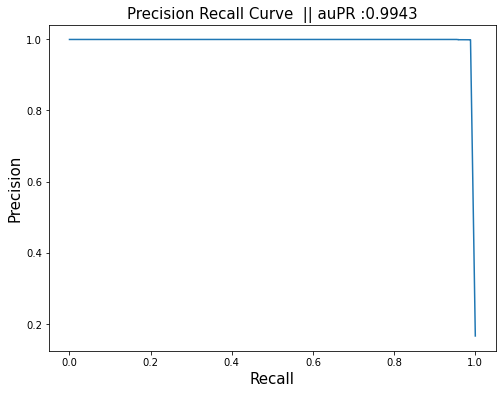

AUC : 0.9943 
Num anomalies 5836


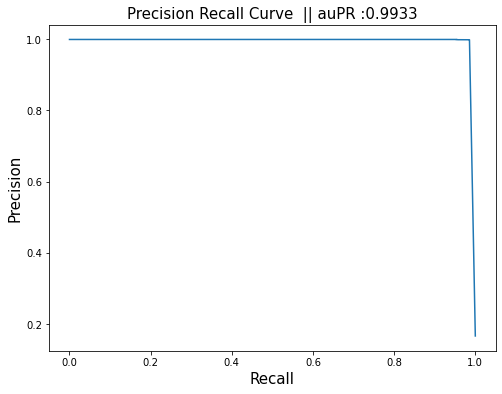

AUC : 0.9933 
Num anomalies 5836


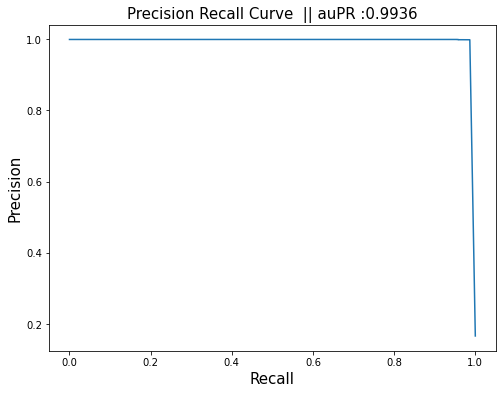

AUC : 0.9936 
Num anomalies 5836


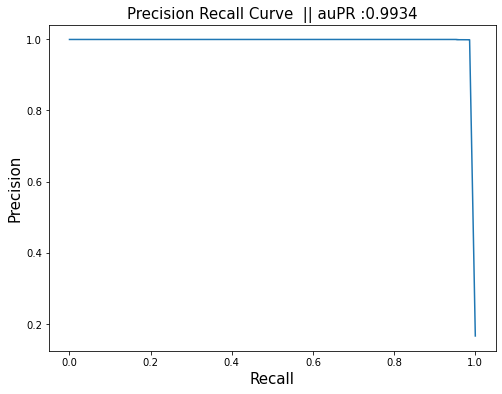

AUC : 0.9934 
Num anomalies 5836


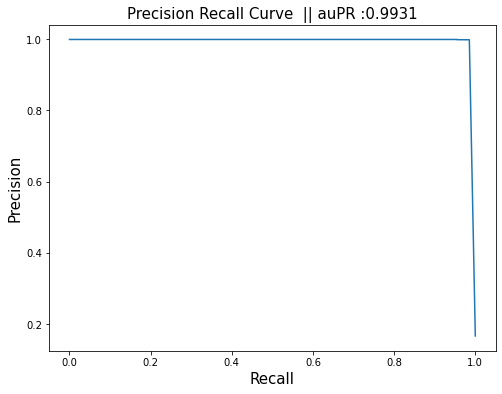

AUC : 0.9931 
 Mean AUC  0.9935438963291008
 AUC std  0.0004268951321196899


In [12]:
auc_list = []
ae_model.mode = 'test'
def _normalize_(val, _min,_max):
    return (val -_min)/(_max - _min)

for idx in range(1, num_anomaly_sets+1):
    key = 'anom_'+str(idx)
    test_anom_df = data_dict[key]
    test_anom_X = test_anom_df.values
    x1 = test_norm_X
    x2 = test_anom_X
  

    x1_scores = ae_model.get_score(x1)
    x2_scores = ae_model.get_score(x2)

    res_data = []
    labels = [ 1 for _ in range(x1.shape[0])] +  [0 for _ in range(x2.shape[0])] 
    _scores = np.concatenate([x1_scores, x2_scores],axis=0)

    for i,j in zip(_scores, labels):
        res_data.append((i[0],j))

    res_df = pd.DataFrame(res_data, columns=['score','label'] )
    res_df = res_df.sort_values(by=['score'],ascending= True)


    _max = max(res_df['score'])
    _min = min(res_df['score'])

    res_df['score'] = res_df['score'].parallel_apply(
        _normalize_,
        args=(_min,_max, )
    )
    _max = max(res_df['score'])
    _min = min(res_df['score'])

    step = (_max - _min)/ 100

    # Vary the threshold
    thresh = _min + step
    thresh = round(thresh,3)
    num_anomalies = x2.shape[0]
    print('Num anomalies',num_anomalies )
    P = []
    R = [0]

    while thresh <= _max+step:

        sel = res_df.loc[res_df['score'] <= thresh]
        if len(sel) == 0 :
            thresh += step
            continue

        correct = sel.loc[sel['label'] == 0 ]

        prec = len(correct)/ len(sel)
        rec = len(correct)/num_anomalies

#         print(thresh, prec, rec, '|| ', len(sel) ,'||' ,len(correct))
        P.append(prec)
        R.append(rec)
        thresh += step

    P = [P[0]] + P
    pr_auc = auc( R, P)
    pr_auc = auc( R, P)

    plt.figure(figsize=[8,6])
    plt.plot(R,P)
    plt.title('Precision Recall Curve  || auPR :' + "{:0.4f}".format(pr_auc), fontsize=15 )
    plt.xlabel('Recall',fontsize=15)
    plt.ylabel('Precision',fontsize=15)
    plt.show()

    print("AUC : {:0.4f} ".format(pr_auc))
    auc_list.append(pr_auc)

    
    
print(' Mean AUC ', np.mean(auc_list))
print(' AUC std ', np.std(auc_list)) 

In [12]:
def viz_loss(losses):
    import matplotlib.pyplot as plt
    plt.figure(figsize=[8,6])
    plt.plot(list(range(len(losses[:]))),losses[:])
    plt.show()
    return

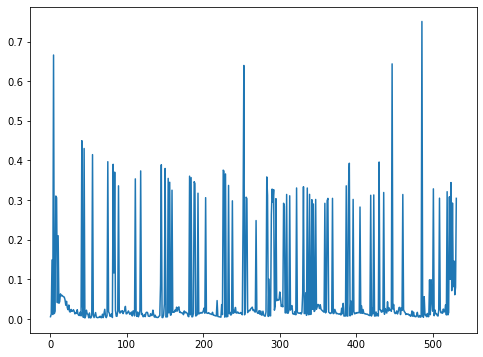

In [13]:
viz_loss(losses)

In [14]:
test_norm_df = data_dict['test']
test_norm_X = test_norm_df.values

In [15]:
test_anom_df = data_dict['anom_1']
test_anom_X = test_anom_df.values
x1 = test_norm_X
x2 = test_anom_X

In [16]:
# pos,neg = model_data_fetcher.fetch_model_data('kddcup')

In [17]:
train_norm_df = data_dict['train']
x0 = train_norm_df.values

In [18]:
neg.shape

(68094, 10, 119)

In [19]:
neg1 = np.reshape(neg,[ neg.shape[0]* neg.shape[1] , neg.shape[2]])
np.random.shuffle(neg1)
neg1.shape

(680940, 119)

In [20]:
x3 = neg1[:10000]

In [ ]:
visualize( ae_model, x1, x2 )

In [22]:
ae_model.mode = 'test'

x1_scores = ae_model.get_score(x1)
x2_scores = ae_model.get_score(x2)

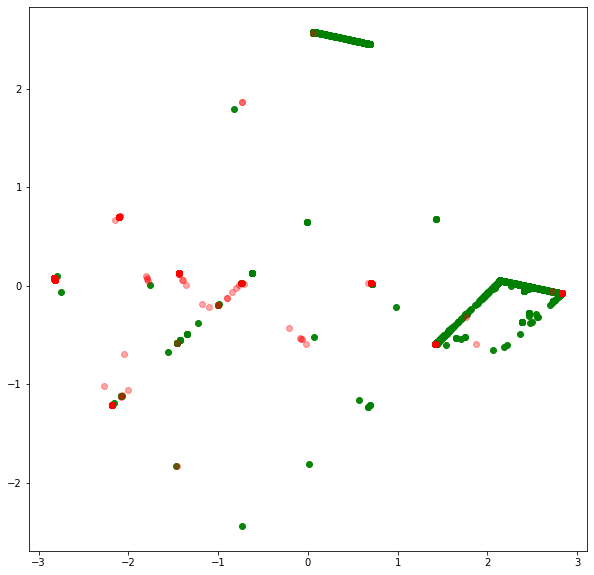

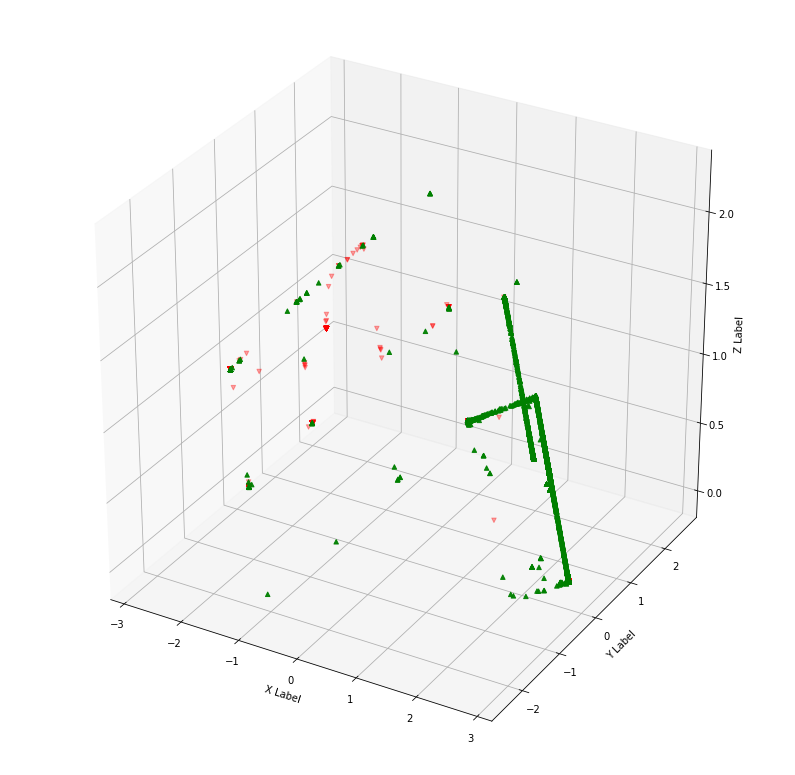

In [23]:
visualize( ae_model, x0, x2 )

In [24]:
x3_scores = ae_model.get_score(x3)
np.min(x3_scores), np.median(x3_scores), np.max(x3_scores)

(0.011721605, 0.011723074, 0.9994091)

In [25]:
def _normalize_(val, _min,_max):
    return (val -_min)/(_max - _min)

In [26]:
import matplotlib.pyplot  as plt

In [27]:
# plt.boxplot(x1_scores)
# plt.show()
np.min(x2_scores), np.median(x2_scores), np.max(x2_scores)

(0.011721605, 0.045568045, 0.99999046)

In [28]:
res_data = []
labels = [ 1 for _ in range(x1.shape[0])] +  [0 for _ in range(x2.shape[0])] 
_scores = np.concatenate([x1_scores, x2_scores],axis=0)

for i,j in zip(_scores, labels):
    res_data.append((i[0],j))
    
res_df = pd.DataFrame(res_data, columns=['score','label'] )
res_df = res_df.sort_values(by=['score'],ascending= True)


_max = max(res_df['score'])
_min = min(res_df['score'])

res_df['score'] = res_df['score'].parallel_apply(
    _normalize_,
    args=(_min,_max, )
)
res_df

In [30]:
_max = max(res_df['score'])
_min = min(res_df['score'])

step = (_max - _min)/ 100

# Vary the threshold
thresh = _min + step
num_anomalies = x2.shape[0]
print('Num anomalies',num_anomalies )
P = []
R = [0]

while thresh <= _max+step:
    
    sel = res_df.loc[res_df['score'] <= thresh]
    if len(sel) == 0 :
        thresh += step
        continue

    correct = sel.loc[sel['label'] == 0 ]
    
    prec = len(correct)/ len(sel)
    rec = len(correct)/num_anomalies
    
    print(thresh, prec, rec, '|| ', len(sel) ,'||' ,len(correct))
    P.append(prec)
    R.append(rec)
    thresh += step
P = [P[0]] + P

Num anomalies 5836
0.01 0.9984126984126984 0.2155586017820425 ||  1260 || 1258
0.02 0.9984126984126984 0.2155586017820425 ||  1260 || 1258
0.03 0.9984126984126984 0.2155586017820425 ||  1260 || 1258
0.04 0.9979835013748855 0.9328307059629883 ||  5455 || 5444
0.05 0.9979835013748855 0.9328307059629883 ||  5455 || 5444
0.060000000000000005 0.9979835013748855 0.9328307059629883 ||  5455 || 5444
0.07 0.9979835013748855 0.9328307059629883 ||  5455 || 5444
0.08 0.9979835013748855 0.9328307059629883 ||  5455 || 5444
0.09 0.9979835013748855 0.9328307059629883 ||  5455 || 5444
0.09999999999999999 0.9979835013748855 0.9328307059629883 ||  5455 || 5444
0.10999999999999999 0.9979835013748855 0.9328307059629883 ||  5455 || 5444
0.11999999999999998 0.9979835013748855 0.9328307059629883 ||  5455 || 5444
0.12999999999999998 0.9979835013748855 0.9328307059629883 ||  5455 || 5444
0.13999999999999999 0.9979835013748855 0.9328307059629883 ||  5455 || 5444
0.15 0.9979835013748855 0.9328307059629883 ||  545

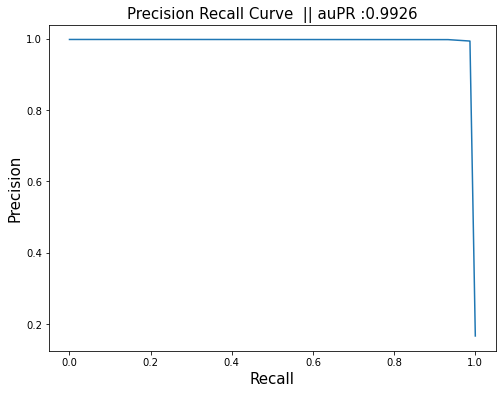

AUC : 0.9926 


In [31]:

from sklearn.metrics import auc
pr_auc = auc( R, P)

plt.figure(figsize=[8,6])
plt.plot(R,P)
plt.title('Precision Recall Curve  || auPR :' + "{:0.4f}".format(pr_auc), fontsize=15 )
plt.xlabel('Recall',fontsize=15)
plt.ylabel('Precision',fontsize=15)
plt.show()


print("AUC : {:0.4f} ".format(pr_auc))

In [337]:
a = torch.FloatTensor(np.random.random([512,1,4]))
a.shape

Current device  >>  cuda


torch.Size([512, 1, 4])

In [341]:
a.squeeze(1).squeeze(1).shape

torch.Size([512, 4])

In [3]:
# Load list of points for cluster analysis.
sample = read_sample(FCPS_SAMPLES.SAMPLE_TWO_DIAMONDS)

In [35]:
from sklearn.datasets.samples_generator import make_blobs
from pyclustering.cluster import cluster_visualizer
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer

In [82]:
centers = [(-5, -5, -6), (5, 5,0),(.25,1.25,2)]
cluster_std = [0.25,1.25,1.75]

X, y = make_blobs(n_samples=100, cluster_std=cluster_std, centers=centers, n_features=3, random_state=1)

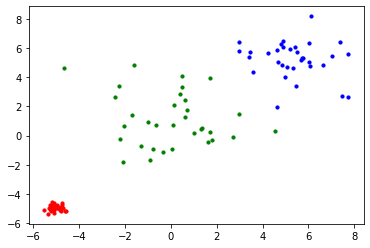

In [83]:
plt.scatter(X[y == 0, 0], X[y == 0, 1], color="red",  s=10, label="Cluster1")
plt.scatter(X[y == 1, 0], X[y == 1, 1], color="blue", s=10, label="Cluster2")
plt.scatter(X[y == 2, 0], X[y == 2, 1], color="green",  s=10, label="Cluster1")


In [100]:
# Prepare initial centers using K-Means++ method.

def x_means(
    X,
    num_init_clusters = 8,
    visualize = True
):
    from pyclustering.cluster.kmeans import kmeans, kmeans_visualizer
    from pyclustering.cluster.xmeans import xmeans
    from pyclustering.cluster import cluster_visualizer
    from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
    from pyclustering.cluster import cluster_visualizer_multidim
    
    X = list(X)
    
    initial_centers = kmeans_plusplus_initializer(
        X, 
        amount_initial_centers
       
    ).initialize()

    start_centers = kmeans_plusplus_initializer(X, num_init_clusters).initialize()
   
    xmeans_instance = xmeans(X, start_centers, 20, ccore=True,  criterion = 0)
        

    # Run cluster analysis and obtain results.
    xmeans_instance.process()
    clusters = xmeans_instance.get_clusters()
    centers = xmeans_instance.get_centers()
    print('Number of cluster centers calculated :', len(centers))

    if visualize :
        visualizer = cluster_visualizer_multidim()
        visualizer.append_clusters(clusters, X)
        visualizer.show()
    return centers,clusters

Number of cluster centers calculated : 4


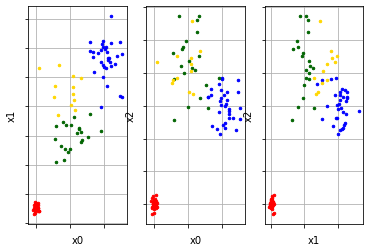

In [101]:

x_means(X,4)

In [31]:
# Prepare initial centers using K-Means++ method.


[array([5.35054598, 3.68771659])]


In [32]:
# Run cluster analysis and obtain results.
xmeans_instance_1.process()
clusters = xmeans_instance_1.get_clusters()
final_centers = xmeans_instance_1.get_centers()

In [33]:
final_centers

[[-4.957007090913727, -5.0115476154679115],
 [1.103508013001677, -1.0740079912115943],
 [1.0081270544323917, 2.3410526260307187],
 [4.899507476842758, 4.9839302284736595]]

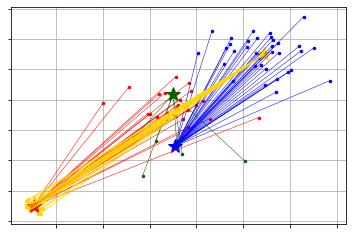

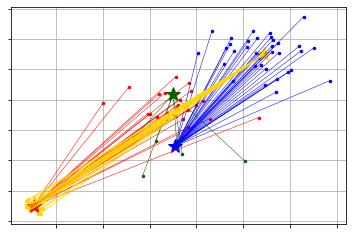

In [62]:
# Visualize obtained results
kmeans_visualizer.show_clusters(X, clusters, final_centers)